In [1]:
using Knet
# mat will flatten tensor. T[K,L,M] - > T[K*L, M]
predict(w,x) = w[1]*mat(x) .+ w[2]
# nll -> negative log likelihood
# y_true = 10 means number is zero
loss(w,x,y_true) = nll(predict(w,x), y_true)
lossgradient = grad(loss)



(::gradfun) (generic function with 1 method)

In [2]:
function train(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
	for i in 1:length(w)
	    w[i] -= lr * dw[i]
	end	    
    end
    return w
end

train (generic function with 1 method)

In [3]:
include(Knet.dir("data","mnist.jl"))
xtrn, ytrn, xtst, ytst = mnist()
dtrn = minibatch(xtrn, ytrn, 100)
dtst = minibatch(xtst, ytst, 100)
# MNIST is 28*28 thus FC layer has 784 to 10 weights. 
# Only has bias in classification layer.
# w[0] -> weights, w[1]-> bias
w = Any[ 0.1f0*randn(Float32,10,784), zeros(Float32,10,1) ]
println((:epoch, 0, :trn, accuracy(w,dtrn,predict), :tst, accuracy(w,dtst,predict)))
for epoch=1:10
    train(w, dtrn; lr=0.5)
    println((:epoch, epoch, :trn, accuracy(w,dtrn,predict), :tst, accuracy(w,dtst,predict)))
end

INFO: Loading MNIST...


(:epoch, 0, :trn, 0.08688333333333334, :tst, 0.0851)
(:epoch, 1, :trn, 0.8996666666666666, :tst, 0.9041)
(:epoch, 2, :trn, 0.90705, :tst, 0.9088)
(:epoch, 3, :trn, 0.9112, :tst, 0.9119)
(:epoch, 4, :trn, 0.9133666666666667, :tst, 0.913)
(:epoch, 5, :trn, 0.9149, :tst, 0.9143)
(:epoch, 6, :trn, 0.9162166666666667, :tst, 0.9153)
(:epoch, 7, :trn, 0.9171333333333334, :tst, 0.9158)
(:epoch, 8, :trn, 0.9182166666666667, :tst, 0.9168)
(:epoch, 9, :trn, 0.9187666666666666, :tst, 0.9168)
(:epoch, 10, :trn, 0.9194833333333333, :tst, 0.9165)


In [4]:
# Instead of a linear model, use Multi Layer Perceptron
# overwrite predict function
function predict(w, x)
    # mat will flatten tensor. T[K,L,M] - > T[K*L, M]
    x = mat(x)
    # W[1] -> w's of 1st layer, w[2]-> b's of 1st layer, so on.
    # Thus W[2k] -> b for k'th layer, w[2k-1] -> b for k'th layer.
    for i=1:2:length(w)-2
        x = relu.(w[i] * x .+ w[i+1])
    end
    return w[end-1] * x .+ w[end]
end

predict (generic function with 1 method)

In [5]:
# Let's initialize with xavier init method
# remember bias are presented in 2nd column
w = Any[xavier(Float32, 64, 784), xavier(Float32, 64, 1),
        xavier(Float32, 10, 64), xavier(Float32, 10, 1)]

4-element Array{Any,1}:
 Float32[0.0140113 -0.0322181 … 0.0430031 0.00508136; -0.036539 0.0203703 … 0.0347628 -0.0221594; … ; -0.0119094 -0.00260076 … -0.00234945 -0.0190336; 0.00169754 0.0415606 … -0.0222434 0.0103525]
 Float32[0.050549; -0.109228; … ; 0.0839572; 0.097709]                                                                                                                                             
 Float32[0.0123196 0.119976 … 0.0667592 -0.137459; -0.0956151 -0.0386136 … 0.0479739 -0.0779063; … ; -0.13497 -0.116501 … -0.0813753 -0.124604; -0.105675 -0.0478672 … -0.133215 0.112879]         
 Float32[-0.0745409; 0.295544; … ; -0.254194; -0.244285]                                                                                                                                           

In [6]:
# Introduce optim and update!
function train(model, data, optim)
    for (x,y) in data
        grads = lossgradient(model, x, y)
        update!(model, grads, optim)
    end
end

train (generic function with 2 methods)

In [7]:
opt = optimizers(w, Adam, gclip=4)
println((:epoch, 0, :trn, accuracy(w,dtrn,predict), :tst, accuracy(w,dtst,predict)))
for epoch=1:10
    train(w, dtrn, opt)
    println((:epoch, epoch, :trn, accuracy(w,dtrn,predict), :tst, accuracy(w,dtst,predict)))
end

(:epoch, 0, :trn, 0.10145, :tst, 0.1055)
(:epoch, 1, :trn, 0.9256833333333333, :tst, 0.9266)
(:epoch, 2, :trn, 0.94575, :tst, 0.9445)
(:epoch, 3, :trn, 0.95885, :tst, 0.9555)
(:epoch, 4, :trn, 0.9661666666666666, :tst, 0.962)
(:epoch, 5, :trn, 0.9708166666666667, :tst, 0.9658)
(:epoch, 6, :trn, 0.9743, :tst, 0.9674)
(:epoch, 7, :trn, 0.9776166666666667, :tst, 0.9707)
(:epoch, 8, :trn, 0.9802166666666666, :tst, 0.9716)
(:epoch, 9, :trn, 0.9819166666666667, :tst, 0.9724)
(:epoch, 10, :trn, 0.9835833333333334, :tst, 0.9735)


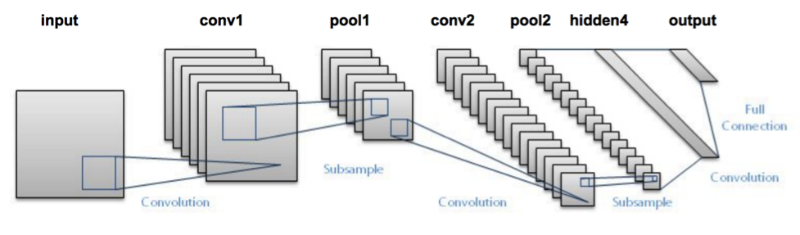

In [8]:
# Boost performance with CNN
function predict(w, x0)
    x1 = pool(relu.(conv4(w[1], x0) .+ w[2]))
    x2 = pool(relu.(conv4(w[3], x1) .+ w[4]))
    x3 = relu.(w[5] * mat(x2) .+ w[6])
    return w[7] * x3 .+ w[8]
end

predict (generic function with 1 method)

In [9]:
# Xavier(Type, Filter height, Filter width, number of channel, number of filter)
w =  Any[xavier(Float32,5,5,1,20),  zeros(Float32,1,1,20,1),
         xavier(Float32,5,5,20,50), zeros(Float32,1,1,50,1),
         xavier(Float32,500,800),   zeros(Float32,500,1),
         xavier(Float32,10,500),    zeros(Float32,10,1)];

In [10]:
opt = optimizers(w, Adam, gclip=4)
println((:epoch, 0, :trn, accuracy(w,dtrn,predict), :tst, accuracy(w,dtst,predict)))
for epoch=1:10
    train(w, dtrn, opt)
    println((:epoch, epoch, :trn, accuracy(w,dtrn,predict), :tst, accuracy(w,dtst,predict)))
end

(:epoch, 0, :trn, 0.13961666666666667, :tst, 0.1395)
(:epoch, 1, :trn, 0.9802, :tst, 0.9809)
(:epoch, 2, :trn, 0.9895333333333334, :tst, 0.9877)
(:epoch, 3, :trn, 0.99285, :tst, 0.9885)
(:epoch, 4, :trn, 0.9924, :tst, 0.9878)
(:epoch, 5, :trn, 0.99335, :tst, 0.9874)
(:epoch, 6, :trn, 0.9943833333333333, :tst, 0.9896)
(:epoch, 7, :trn, 0.9964333333333333, :tst, 0.9909)
(:epoch, 8, :trn, 0.9941833333333333, :tst, 0.9886)
(:epoch, 9, :trn, 0.9965833333333334, :tst, 0.9916)
(:epoch, 10, :trn, 0.9943166666666666, :tst, 0.9884)
